Importing the dataset

In [1]:
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings("ignore")
data=pd.read_csv('space_traffic.csv')

In [2]:
data.head()

,Timestamp,Location,Object_Type,Traffic_Density,Peak_Time
0,2024-10-21 21:00:00,Lagrange Point L2,Space Station,17,15:00
1,2024-10-11 05:00:00,Orbit LEO,Satellite,21,15:00
2,2024-10-29 13:00:00,Orbit LEO,Space Station,88,6:00
3,2024-10-24 08:00:00,Mars Transfer Orbit,Scientific Probe,65,8:00
4,2024-10-23 17:00:00,Lagrange Point L1,Space Station,9,6:00


# Feature Engineering

In [3]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Convert 'Timestamp' to datetime format
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# Extract features from the timestamp
data['Hour'] = data['Timestamp'].dt.hour
data['Day_of_Week'] = data['Timestamp'].dt.dayofweek
data['Day_of_Month'] = data['Timestamp'].dt.day

# Encode categorical features using LabelEncoder
label_encoder_location = LabelEncoder()
label_encoder_object = LabelEncoder()

data['Location_Encoded'] = label_encoder_location.fit_transform(data['Location'])
data['Object_Type_Encoded'] = label_encoder_object.fit_transform(data['Object_Type'])

# Define features (X) and target (y)
X = data[['Location_Encoded', 'Object_Type_Encoded', 'Hour', 'Day_of_Week', 'Day_of_Month']]
y = data['Traffic_Density']

# Standardize the target variable
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1))

1.  Converted the 'Timestamp' column to datetime format and extracted relevant time-related features like 'Hour', 'Day_of_Week', and 'Day_of_Month' from it.
2.  Applied preprocessing steps using ColumnTransformer to one-hot encode categorical variables and scaled the target variable (Traffic_Density) using StandardScaler.



In [4]:
print(X)

     Location_Encoded  Object_Type_Encoded  Hour  Day_of_Week  Day_of_Month
0                   1                    5    21            0            21
1                   4                    2     5            4            11
2                   4                    5    13            1            29
3                   2                    3     8            3            24
4                   0                    5    17            2            23
..                ...                  ...   ...          ...           ...
995                 5                    0    13            0            28
996                 0                    0     1            6            13
997                 5                    4    21            6             6
998                 1                    1     6            3             3
999                 1                    4    12            6             6

[1000 rows x 5 columns]


# Linear Regression

Linear regression is a statistical method used to model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. It predicts the value of the dependent variable by minimizing the sum of squared differences between the observed and predicted values.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split the processed data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Linear Regression model
model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Output results
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")


Mean Squared Error (MSE): 1.0268463868554196
R² Score: -0.006034119149835648


Interpretation: This model is underperforming. An R² score of -0.03 means it is worse than a simple horizontal line (predicting the mean value), which indicates that the model is not capturing the variance in the data.

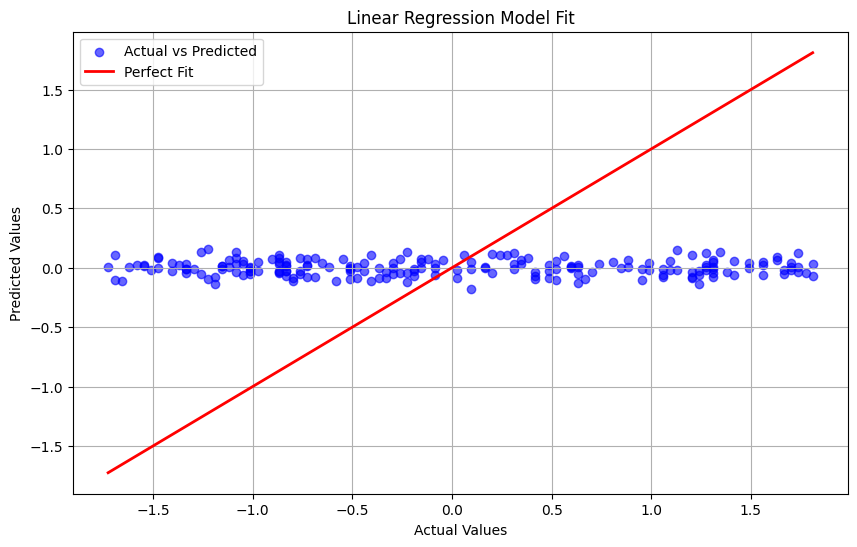

In [6]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Actual vs Predicted')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2, label='Perfect Fit')
plt.title('Linear Regression Model Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.legend()
plt.grid(True)
plt.show()


## Cross Validation Results

Cross-validation is a technique used to assess the performance of a machine learning model by splitting the data into multiple subsets, training the model on some and testing it on others. It helps in ensuring that the model's performance is robust and not dependent on a particular subset of data.

In [7]:
from sklearn.model_selection import cross_val_score

# Cross-validation with 5 folds, using R² score as the metric
cv_scores_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')

# Mean and standard deviation of cross-validation R² scores
print(f"Cross-validated R² score: {np.mean(cv_scores_r2)}")
print(f"Standard deviation of R² scores: {np.std(cv_scores_r2)}")

Cross-validated R² score: -0.008935263569921447
Standard deviation of R² scores: 0.00532714924995567


The negative Mean Squared Error (MSE) from cross-validation (-1.01) indicates that the model is not doing well at predicting the traffic density. This suggests that either the data features or the model choice may not be suitable for the task.

## Test set performance

In [8]:
for test_size in [0.1, 0.2, 0.3, 0.4]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Test Size: {test_size} - MSE: {mse}, R²: {r2}")


Test Size: 0.1 - MSE: 1.1389026687160175, R²: -0.0037673405965645834
Test Size: 0.2 - MSE: 1.0268463868554196, R²: -0.006034119149835648
Test Size: 0.3 - MSE: 0.9751696903003236, R²: -0.012056767067108343
Test Size: 0.4 - MSE: 1.0049611285510927, R²: -0.003838926341785509


# Regularization Models

## Ridge Regression

Ridge regression is a type of linear regression that adds a penalty term to the loss function, which is the sum of the squared coefficients multiplied by a regularization parameter (lambda). This penalty helps prevent overfitting by reducing the magnitude of the model's coefficients, promoting simpler models.

In [10]:
from sklearn.linear_model import Ridge

# Initialize Ridge model
ridge_model = Ridge(alpha=1.0)  # You can experiment with different alpha values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Ridge Regression
ridge_model.fit(X_train, y_train)

# Predict using Ridge Regression
ridge_pred = ridge_model.predict(X_test)

# Evaluate Ridge Regression
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

print(f"Ridge Regression - Mean Squared Error (MSE): {ridge_mse}")
print(f"Ridge Regression - R² Score: {ridge_r2}")

# Cross-validation for Ridge
ridge_cv_scores = cross_val_score(ridge_model, X, y, cv=5, scoring='r2')

print(f"Ridge Cross-validated R² score: {np.mean(ridge_cv_scores)}")
print(f"Ridge Standard deviation of R² scores: {np.std(ridge_cv_scores)}")


Ridge Regression - Mean Squared Error (MSE): 1.0268449902152865
Ridge Regression - R² Score: -0.006032750817002386
Ridge Cross-validated R² score: -0.008934009510448515
Ridge Standard deviation of R² scores: 0.005324571697618964


Ridge slightly improves over basic Linear Regression, showing the impact of L2 regularization in stabilizing the model, but it still fails to achieve a positive R² score.

## Ridge Regression with tuning

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# Define the parameter grid for Ridge
ridge_param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Initialize Ridge and GridSearchCV
ridge_grid_search = GridSearchCV(Ridge(), ridge_param_grid, cv=5, scoring='r2')

# Fit GridSearchCV on the processed data
ridge_grid_search.fit(X_train, y_train)

# Best parameter and corresponding score
print(f"Best alpha for Ridge: {ridge_grid_search.best_params_['alpha']}")
print(f"Best R² score for Ridge: {ridge_grid_search.best_score_}")

Best alpha for Ridge: 100
Best R² score for Ridge: -0.0177382989718865


Ridge improved slightly with a higher regularization strength (alpha=100). The result suggests the need for further feature refinement or scaling adjustments to reduce the negative R² score.

## Lasso Regression

Lasso regression (Least Absolute Shrinkage and Selection Operator) is a linear regression technique that adds a penalty term to the loss function, which is the sum of the absolute values of the coefficients multiplied by a regularization parameter (lambda). This results in some coefficients being reduced to zero, effectively performing feature selection and simplifying the model.

In [12]:
from sklearn.linear_model import Lasso

# Initialize Lasso model
lasso_model = Lasso(alpha=0.1)  # You can experiment with different alpha values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Lasso Regression
lasso_model.fit(X_train, y_train)

# Predict using Lasso Regression
lasso_pred = lasso_model.predict(X_test)

# Evaluate Lasso Regression
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print(f"Lasso Regression - Mean Squared Error (MSE): {lasso_mse}")
print(f"Lasso Regression - R² Score: {lasso_r2}")

# Cross-validation for Lasso
lasso_cv_scores = cross_val_score(lasso_model, X, y, cv=5, scoring='r2')

print(f"Lasso Cross-validated R² score: {np.mean(lasso_cv_scores)}")
print(f"Lasso Standard deviation of R² scores: {np.std(lasso_cv_scores)}")

Lasso Regression - Mean Squared Error (MSE): 1.0238404383561348
Lasso Regression - R² Score: -0.003089095639602135
Lasso Cross-validated R² score: -0.008061365703628098
Lasso Standard deviation of R² scores: 0.004037688416173089


Lasso performs better than Ridge, with a much smaller negative R² score. Its L1 regularization might have pruned some unnecessary features, leading to improved performance.

## Lasso Regression with tuning

In [13]:
# Define the parameter grid for Lasso
lasso_param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

# Initialize Lasso and GridSearchCV
lasso_grid_search = GridSearchCV(Lasso(), lasso_param_grid, cv=5, scoring='r2')

# Fit GridSearchCV on the processed data
lasso_grid_search.fit(X_train, y_train)

# Best parameter and corresponding score
print(f"Best alpha for Lasso: {lasso_grid_search.best_params_['alpha']}")
print(f"Best R² score for Lasso: {lasso_grid_search.best_score_}")


Best alpha for Lasso: 1
Best R² score for Lasso: -0.00974720749070399


Lasso performs better than Ridge overall, with a nearly neutral R² score. This indicates Lasso's effectiveness in handling sparse or less significant features.

# KNN Regressor

K-Nearest Neighbors (KNN) Regressor is a non-parametric algorithm that predicts the value of a target variable by averaging the values of the k-nearest data points in the feature space. It relies on the assumption that similar data points are close to each other, and the value is determined based on the proximity of the data points in the feature space.

In [14]:
from sklearn.neighbors import KNeighborsRegressor

# Initialize the KNN Regressor
knn_model = KNeighborsRegressor(n_neighbors=5)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the KNN Regressor
knn_model.fit(X_train, y_train)

# Predict using KNN Regressor
knn_pred = knn_model.predict(X_test)

# Evaluate the KNN Regressor
knn_mse = mean_squared_error(y_test, knn_pred)
knn_r2 = r2_score(y_test, knn_pred)

print(f"KNN Regressor - Mean Squared Error (MSE): {knn_mse}")
print(f"KNN Regressor - R² Score: {knn_r2}")

# Cross-validation for KNN Regressor
knn_cv_scores = cross_val_score(knn_model, X, y, cv=5, scoring='r2')

print(f"KNN Cross-validated R² score: {np.mean(knn_cv_scores)}")
print(f"KNN Standard deviation of R² scores: {np.std(knn_cv_scores)}")


KNN Regressor - Mean Squared Error (MSE): 1.2763956782396944
KNN Regressor - R² Score: -0.250525510224471
KNN Cross-validated R² score: -0.13518462006960172
KNN Standard deviation of R² scores: 0.024490324370940657


KNN performs worse than Ridge and Lasso, likely because it relies on distance metrics and struggles with this dataset's structure, possibly due to scaling issues or sparse data.


## KNN Regressor with tuning

In [15]:
# Define the parameter grid for KNN
knn_param_grid = {'n_neighbors': [3, 5, 7, 9, 11]}

# Initialize KNN and GridSearchCV
knn_grid_search = GridSearchCV(KNeighborsRegressor(), knn_param_grid, cv=5, scoring='r2')

# Fit GridSearchCV on the processed data
knn_grid_search.fit(X_train, y_train)

# Best parameter and corresponding score
print(f"Best n_neighbors for KNN: {knn_grid_search.best_params_['n_neighbors']}")
print(f"Best R² score for KNN: {knn_grid_search.best_score_}")


Best n_neighbors for KNN: 11
Best R² score for KNN: -0.08148360974478783


KNN struggles significantly even with optimized neighbors.

# Random Forest Regressor

Random Forest Regressor is an ensemble learning method that builds multiple decision trees during training and averages their predictions for regression tasks. It helps improve accuracy by reducing overfitting, as each tree is trained on a random subset of the data and features, making the model more robust and less sensitive to noise.

In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Initialize Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model on training data
rf_model.fit(X_train, y_train.ravel())

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the performance
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_r2 = r2_score(y_test, y_pred_rf)

# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X, y.ravel(), cv=5, scoring='r2')

print(f"Random Forest - Mean Squared Error (MSE): {rf_mse}")
print(f"Random Forest - R² Score: {rf_r2}")
print(f"Random Forest Cross-validated R² score: {np.mean(rf_cv_scores)}")
print(f"Random Forest Standard deviation of R² scores: {np.std(rf_cv_scores)}")

Random Forest - Mean Squared Error (MSE): 1.2651910443121517
Random Forest - R² Score: -0.23954797340106015
Random Forest Cross-validated R² score: -0.12955088521403865
Random Forest Standard deviation of R² scores: 0.016085414023598872


Random Forest did not perform well, as indicated by the negative R² score and relatively high MSE. This could be due to:
  
  Insufficiently complex patterns in the dataset for the ensemble to leverage.
  
  Overfitting on training data while failing to generalize.

# Gradient Boosting Regressor

Gradient Boosting Regressor is an ensemble learning technique that builds a series of decision trees in a sequential manner, where each new tree corrects the errors made by the previous ones. It optimizes the model by minimizing the residual errors through gradient descent, resulting in a strong predictive model by combining weak learners (trees).

In [17]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Fit the model on training data
gb_model.fit(X_train, y_train.ravel())

# Predict on the test data
y_pred_gb = gb_model.predict(X_test)

# Evaluate the performance
gb_mse = mean_squared_error(y_test, y_pred_gb)
gb_r2 = r2_score(y_test, y_pred_gb)

# Cross-validation
gb_cv_scores = cross_val_score(gb_model, X, y.ravel(), cv=5, scoring='r2')

print(f"Gradient Boosting - Mean Squared Error (MSE): {gb_mse}")
print(f"Gradient Boosting - R² Score: {gb_r2}")
print(f"Gradient Boosting Cross-validated R² score: {np.mean(gb_cv_scores)}")
print(f"Gradient Boosting Standard deviation of R² scores: {np.std(gb_cv_scores)}")

Gradient Boosting - Mean Squared Error (MSE): 1.1899614894409494
Gradient Boosting - R² Score: -0.16584318178110347
Gradient Boosting Cross-validated R² score: -0.04955087189719136
Gradient Boosting Standard deviation of R² scores: 0.03223903683071024


Gradient Boosting performed slightly better than Random Forest, but still yielded a negative R² score. Its sequential nature may be slightly better suited for this data, but issues with feature relevance or dataset quality persist.

# TIME SERIES PREDICTION

Time series prediction involves forecasting future values based on historical data points, typically ordered by time.

In [18]:
data=pd.read_csv('space_traffic.csv')
print(data.head())

             Timestamp             Location       Object_Type  \
0  2024-10-21 21:00:00    Lagrange Point L2     Space Station   
1  2024-10-11 05:00:00            Orbit LEO         Satellite   
2  2024-10-29 13:00:00            Orbit LEO     Space Station   
3  2024-10-24 08:00:00  Mars Transfer Orbit  Scientific Probe   
4  2024-10-23 17:00:00    Lagrange Point L1     Space Station   

   Traffic_Density Peak_Time  
0               17     15:00  
1               21     15:00  
2               88      6:00  
3               65      8:00  
4                9      6:00  


In [19]:
# Convert Timestamp to datetime
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [20]:
# Sort data by Timestamp
data = data.sort_values(by='Timestamp')

In [21]:
# Extract time-based features
data['Hour'] = data['Timestamp'].dt.hour
data['Day_of_Week'] = data['Timestamp'].dt.dayofweek
data['Day_of_Month'] = data['Timestamp'].dt.day

In [22]:
# Convert Peak_Time to integer (hour format)
data['Peak_Time'] = data['Peak_Time'].apply(lambda x: int(x.split(':')[0]))

In [23]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder_location = LabelEncoder()
label_encoder_object_type = LabelEncoder()

# Encode the 'Location' and 'Object_Type' columns
data['Location'] = label_encoder_location.fit_transform(data['Location'])
data['Object_Type'] = label_encoder_object_type.fit_transform(data['Object_Type'])

In [24]:
# Create lag features for Traffic_Density
data['Lag_1'] = data['Traffic_Density'].shift(1)
data['Lag_6'] = data['Traffic_Density'].shift(6)
data['Lag_24'] = data['Traffic_Density'].shift(24)

In [25]:
# Drop rows with NaN values introduced by lagging
data = data.dropna()

In [26]:
data.head()

,Timestamp,Location,Object_Type,Traffic_Density,Peak_Time,Hour,Day_of_Week,Day_of_Month,Lag_1,Lag_6,Lag_24
202,2024-10-01 18:00:00,0,1,47,9,18,1,1,85.0,63.0,2.0
718,2024-10-01 19:00:00,5,5,59,7,19,1,1,47.0,97.0,2.0
825,2024-10-01 19:00:00,5,3,78,17,19,1,1,59.0,60.0,53.0
438,2024-10-01 19:00:00,0,4,22,8,19,1,1,78.0,72.0,28.0
948,2024-10-01 21:00:00,1,0,19,18,21,1,1,22.0,51.0,66.0


In [27]:
# Features and target variable
X = data.drop(['Timestamp', 'Traffic_Density'], axis=1)
y = data['Traffic_Density']

## ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a time series forecasting model that combines autoregression, differencing, and moving averages to model and predict univariate data. It is effective for stationary time series without seasonality.

ADF Statistic: -30.569924929807144, p-value: 0.0
Series is stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

Mean Squared Error (MSE): 791.4355620995686
R² Score: -0.006206246564706586


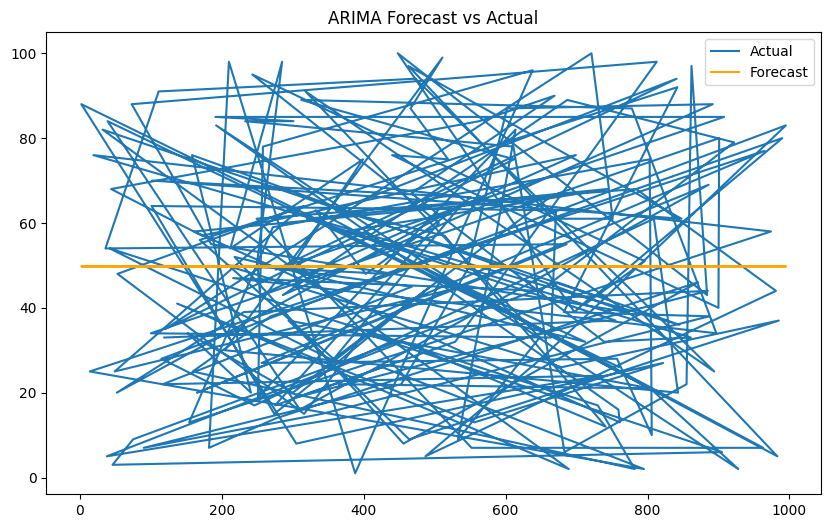

In [28]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Use only Traffic_Density for univariate analysis
series = data['Traffic_Density']

# ADF test to check stationarity
adf_test = adfuller(series)
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Series is not stationary. Differencing required.")
    series_diff = series.diff().dropna()
else:
    print("Series is stationary.")
    series_diff = series

# Train-test split (80-20 split)
train_size = int(0.8 * len(series_diff))
train, test = series_diff[:train_size], series_diff[train_size:]

# Fit ARIMA model (p=1, d=1, q=1 as an example)
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(test))

# Evaluate
mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Forecast", color='orange')
plt.legend()
plt.title("ARIMA Forecast vs Actual")
plt.show()

Mean Squared Error (MSE): The value of 791.44 indicates the average squared difference between the actual and predicted traffic densities. This suggests there is significant room for improvement in the prediction accuracy.

R² Score: A value of -0.0062 indicates that the ARIMA model fails to explain any of the variance in the test data. The model performs slightly worse than a horizontal line (mean predictor).

## SARIMAX

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors) extends ARIMA by adding seasonal components and incorporating external variables (exogenous regressors), making it suitable for time series data with seasonality and external influences.

ADF Statistic: -30.569924929807144, p-value: 0.0
Series is stationary.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Squared Error (MSE): 803.8317028610103
R² Score: -0.021966309499418024


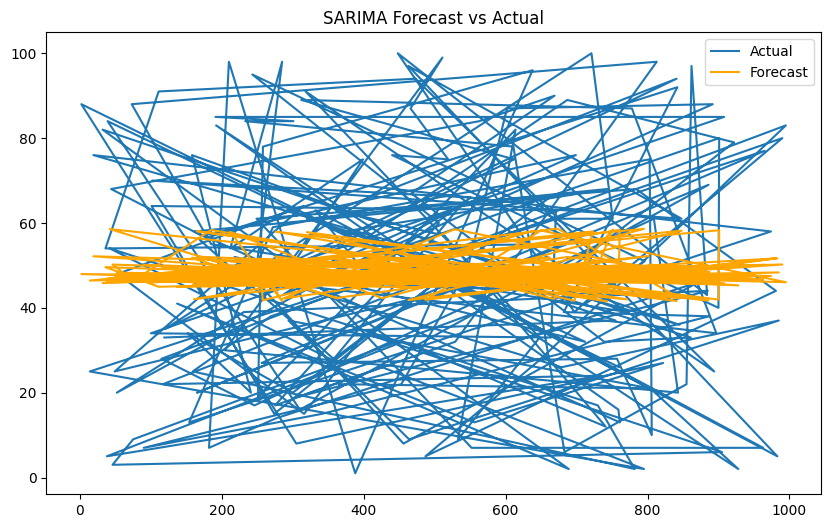

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Use only Traffic_Density for univariate analysis
series = data['Traffic_Density']

# Check stationarity using ADF test
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(series)
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")
if adf_test[1] > 0.05:
    print("Series is not stationary. Differencing required.")
    series_diff = series.diff().dropna()
else:
    print("Series is stationary.")
    series_diff = series

# Train-test split (80-20 split)
train_size = int(0.8 * len(series_diff))
train, test = series_diff[:train_size], series_diff[train_size:]

# Fit SARIMA model (p=1, d=1, q=1) and (P=1, D=1, Q=1, s=12) as an example
sarima_model = SARIMAX(train,
                       order=(1, 1, 1),
                       seasonal_order=(1, 1, 1, 12),
                       enforce_stationarity=False,
                       enforce_invertibility=False)
sarima_fit = sarima_model.fit(disp=False)

# Forecast
forecast = sarima_fit.forecast(steps=len(test))

# Evaluate
mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)
print(f"Mean Squared Error (MSE): {mse}")
print(f"R² Score: {r2}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, forecast, label="Forecast", color='orange')
plt.legend()
plt.title("SARIMA Forecast vs Actual")
plt.show()

Mean Squared Error (MSE): High error suggests the model struggles to match actual traffic density values.

R² Score: The negative value means the model performs worse than a baseline model that predicts the mean for all observations.

## RNN

RNN is a type of neural network designed for sequence data, where connections between nodes form a cycle, allowing information to persist. It is particularly useful for tasks such as time series prediction, language modeling, and speech recognition, as it captures temporal dependencies and patterns in sequential data.

In [30]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM

# Scaling the target variable (Traffic_Density)
scaler = MinMaxScaler()
data['Traffic_Density_Scaled'] = scaler.fit_transform(data['Traffic_Density'].values.reshape(-1, 1))

# Convert Timestamp to datetime and set as index
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data.set_index('Timestamp', inplace=True)

# Define features and target
X = data[['Hour', 'Peak_Time', 'Day_of_Week', 'Day_of_Month']].values
y = data['Traffic_Density_Scaled'].values

# Create sequences for time series data
def create_sequences(X, y, sequence_length=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

sequence_length = 5
X_seq, y_seq = create_sequences(X, y, sequence_length)

# Train-test split
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]


In [31]:
# Build the RNN Model
rnn_model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    Dense(1)
])

# Compile the model
rnn_model.compile(optimizer='adam', loss='mse')

# Train the model
rnn_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred_rnn = rnn_model.predict(X_test)
y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluation
from sklearn.metrics import mean_squared_error, r2_score
mse_rnn = mean_squared_error(y_test_actual, y_pred_rnn)
r2_rnn = r2_score(y_test_actual, y_pred_rnn)
print(f"RNN - Mean Squared Error (MSE): {mse_rnn}")
print(f"RNN - R² Score: {r2_rnn}")


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 18.8036 - val_loss: 1.6342
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2608 - val_loss: 0.7505
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4830 - val_loss: 0.4675
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3018 - val_loss: 0.4341
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2419 - val_loss: 0.3051
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1726 - val_loss: 0.2721
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1623 - val_loss: 0.2812
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1411 - val_loss: 0.2183
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1343 - val_loss: 0.2362
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1292 - val_loss: 0.2083
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1175 - val_loss: 0.2309
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1133 - val_l

The RNN model's high MSE (1398.91) and negative R² score (-0.777) indicate poor performance, suggesting it fails to capture data patterns and performs worse than a baseline model. Refining preprocessing, hyperparameters, and architecture (e.g., using LSTM or GRU) could improve results.

## GRU

GRU (Gated Recurrent Unit) is a type of recurrent neural network (RNN) similar to LSTM but with a simpler structure. It uses two gates—update and reset—to control the flow of information and maintain long-term dependencies in sequential data. GRUs are computationally more efficient than LSTMs and often perform similarly on tasks like time series forecasting and natural language processing.

In [32]:
# Build the GRU Model
gru_model = Sequential([
    GRU(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    Dense(1)
])

# Compile the model
gru_model.compile(optimizer='adam', loss='mse')

# Train the model
gru_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred_gru = gru_model.predict(X_test)
y_pred_gru = scaler.inverse_transform(y_pred_gru)

# Evaluation
mse_gru = mean_squared_error(y_test_actual, y_pred_gru)
r2_gru = r2_score(y_test_actual, y_pred_gru)
print(f"GRU - Mean Squared Error (MSE): {mse_gru}")
print(f"GRU - R² Score: {r2_gru}")


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7287 - val_loss: 0.2990
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1149 - val_loss: 0.1549
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0914 - val_loss: 0.1167
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0866 - val_loss: 0.1172
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0876 - val_loss: 0.0988
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0796 - val_loss: 0.1008
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0793 - val_loss: 0.1421
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0852 - val_loss: 0.2131
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0908 - val_loss: 0.0967
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0735 - val_loss: 0.0940
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0785 - val_loss: 0.0946
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0739 - val_l

The GRU model's MSE of 1120.66 and R² score of -0.424 indicate suboptimal performance, with the model unable to accurately predict the data patterns and performing worse than a baseline. Improving feature engineering, tuning hyperparameters, or considering alternative architectures might enhance performance.

## LSTM

LSTM (Long Short-Term Memory) is a type of recurrent neural network (RNN) designed to handle long-term dependencies in sequential data. Unlike traditional RNNs, LSTMs use special units called "memory cells" to store information over long periods, overcoming the vanishing gradient problem. This makes LSTMs particularly effective for tasks like time series forecasting, speech recognition, and language translation.

In [33]:
# Build the LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])),
    Dense(1)
])

# Compile the model
lstm_model.compile(optimizer='adam', loss='mse')

# Train the model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predictions
y_pred_lstm = lstm_model.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)

# Evaluation
mse_lstm = mean_squared_error(y_test_actual, y_pred_lstm)
r2_lstm = r2_score(y_test_actual, y_pred_lstm)
print(f"LSTM - Mean Squared Error (MSE): {mse_lstm}")
print(f"LSTM - R² Score: {r2_lstm}")


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.5392 - val_loss: 0.3101
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1823 - val_loss: 0.2609
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1467 - val_loss: 0.2228
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1236 - val_loss: 0.1856
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1041 - val_loss: 0.1820
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1050 - val_loss: 0.1653
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1003 - val_loss: 0.2128
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1002 - val_loss: 0.1559
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0877 - val_loss: 0.1502
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0935 - val_loss: 0.1780
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0818 - val_loss: 0.1371
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0857 - val_lo

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
LSTM - Mean Squared Error (MSE): 1756.212642040543
LSTM - R² Score: -1.2308936582939531


The LSTM model has a high MSE of 1832.86 and a negative R² score of -1.33, indicating poor model performance and that the model is significantly underfitting the data, performing worse than a simple mean-based predictor. Further adjustments in the model architecture or data preprocessing may be needed.